<a href="https://colab.research.google.com/github/simonka0808/AdaptiveSolutionsCorrectCode/blob/main/2022_CM4107_CW_1_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Submission Information
---

How to get the link to submit the notebook ?
*   Click the Share button (Top right corner)
*   In Get Link section, click change and choose **anyone with link**
* Make sure the access shows **"Editor"**
* Click on **Copy link**

Find below screenshot for reference.

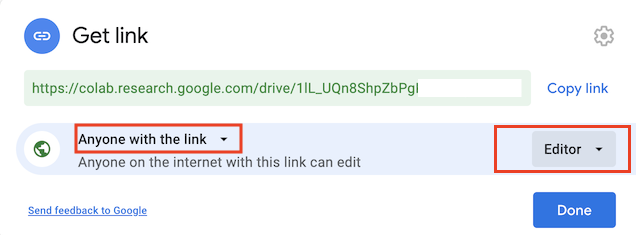

Please complete the below section

In [18]:
# Student Name = Simona Georgieva
# Student ID = 1900745  
# Student Email = s.georgieva@rgu.ac.uk

# Helper functions and imports

In [19]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy.special

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import os
# helper to load data from PNG image files# helpe 
import imageio
# glob helps select multiple files using patterns
import glob
# helps to manipulate the image for rotation 


In [20]:
from __future__ import division # backward compatibility for python2
import operator
import random


np.random.seed(42)

## Import dataset

In [17]:
# file paths to MNIST on Colab
train_file = "sample_data/mnist_train_small.csv"
test_file = "sample_data/mnist_test.csv"

## Data Preprocessing

In [ ]:
df_orig_train = pd.read_csv(train_file, header=None)  # read entire train dataset
df_orig_test = pd.read_csv(test_file, header=None)  # read entire test dataset
df_orig_train.info()

#all of the train data
y_train_all =  pd.get_dummies(df_orig_train[0]).values # Dataframes converted to ndarrays here
X_train_all = df_orig_train.drop(0, axis = 1).values
print(y_train_all.shape)
print(X_train_all.shape)
#all of the test data
y_test_all =  pd.get_dummies(df_orig_test[0]).values
X_test_all = df_orig_test.drop(0, axis = 1).values
print(y_test_all.shape)
print(X_test_all.shape)

# Select smaller samples of the train and test datasets (will execute faster when training our networks than using the entire dataset)
train_sample_size = 20000 # choosing a smaller sample instead of the entire dataset
random_indices = np.random.choice(range(len(y_train_all)), train_sample_size, replace = False)
X_train = X_train_all[random_indices]
y_train = y_train_all[random_indices]
print(y_train.shape)
print(X_train.shape)
#preprocessing normalise training data
X_train = (X_train / 255.0 * 0.99) + 0.01
y_train = y_train + 0.01
y_train = np.where(y_train != 1.01, y_train, 0.99)
print(y_train.shape)

# get a smaller test sample 
test_sample_size = 10000
random_test_indices = np.random.choice(range(len(y_test_all)), test_sample_size, replace = False)
X_test = X_test_all[random_test_indices]
y_test = y_test_all[random_test_indices]
print(y_test.shape)
print(X_test.shape)
#preprocessing normalise test data
X_test = (X_test / 255.0 * 0.99) + 0.01
y_test = y_test + 0.01
y_test = np.where(y_test != 1.01, y_test, 0.99)

In [22]:
def mean_squared_error(predictions, targets):
    """
    Calculates mean squared error of a model's predictions.
    """
    N=targets.size
    mse = ((targets - predictions) **2).sum() / (2*N)
    return mse


def accuracy(predictions, targets):
    """
    Calculates the accuracy of a model's predictions.
    """
    prediction_labels = np.argmax(predictions, axis=1)
    target_labels = np.argmax(targets, axis=1)
    predictions_correct = (prediction_labels == target_labels.round())
    accuracy = predictions_correct.mean()
    return accuracy

# TASK 1 - Activation functions for ANN
---

In labs you explored Sigmoid and ReLU.

In [23]:
class Activation_ReLU:
    def forward(self, x):
        return(np.maximum(0, x))
    def backward(self, x):
       return(np.greater_equal(x, 0).astype(int)) # inputs > 0 then convert bools to int
 
        
class Activation_Sigmoid:
    def forward(self, x):
        return(1 / (1 + np.exp(-x)))
    def backward(self, x):
        return(x * ( 1 - x))


## 1.1 (a) Implement LeakyReLU activation function

In [98]:
class Activation_LeakyReLU:
    def forward(self, inputs, alpha = 0.0001):
        # TODO: 
        return np.maximum(alpha*inputs,inputs)

    def backward(self, inputs, alpha = 0.0001):
        # TODO:  # inputs > ALPHA then convert bools to int
         # inputs > 0 then convert bools to int
        return(np.greater_equal(inputs, alpha).astype(int))

      

## 1.1 (b) Implement Linear activation function

In [99]:
class Activation_Linear:
    def forward(self, inputs, m=1, c=0):
       # TODO: # linear equation where m and c can be set
       return (m*inputs) + c


    def backward(self, inputs, m=1, c=0):
       # TODO:
       return m

In [100]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # weights initialised from a gaussian with mean 0 and variance 1
        # multiply with a small value just to ensure we start with small weight values
        self.weights = 0.1*  np.random.normal(0.0, pow(n_inputs, -0.5), (n_inputs, n_neurons))
        self.biases = np.zeros((1, n_neurons))
       
    def forward(self, inputs, act):
        self.inputs = inputs #need this when backpropagating so maintain it in the layer class
        z = np.dot(inputs , self.weights) + self.biases # weights dot product
        self.outputs = act.forward(z) # nonlinear activation output of the layer
            
    def backward(self, error, act):
        delta = error * act.backward(self.outputs)
        self.dinputs = np.dot(delta, self.weights.T)  #this layer's error 
        
        N = self.dinputs.shape[0]
        self.dweights = np.dot(self.inputs.T, delta) / N  # derivatives for weights used by the optimizer class  
        self.dbiases = np.mean(delta, axis=0, keepdims=True) # derivatives for biases used by the optimizer class 
    
    
class Optimizer_SGD:
    def __init__(self, learningrate=0.3):
           self.lr = learningrate
            
    def weight_update(self, layer):       
        layer.weights -= self.lr * layer.dweights
        layer.biases -= self.lr * layer.dbiases

In [101]:
class ANN():
    def __init__(self, ouput_layer, act2, hidden_layer, act1, opt, batch_size = 10):
        self.layer2 = ouput_layer
        self.act2 = act2
        self.layer1 = hidden_layer
        self.act1 = act1
        self.opt = opt
        self.batch_size = batch_size

    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])

    def train(self, x, y, epochs, opt, lr=0.3):
        opt.lr = lr

        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):

            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x, self.act1)
                self.layer2.forward(self.layer1.outputs, self.act2)

                #calculate the loss
                loss=(self.layer2.outputs-batch_y)
                
                # backprop through the layers 
                self.layer2.backward(loss, self.act2)
                self.layer1.backward(self.layer2.dinputs, self.act1)

                # update all the layer weights
                self.opt.weight_update(self.layer1)
                self.opt.weight_update(self.layer2)
               

            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)   
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)
        return self.layer2.outputs


    def embeddings(self, x, layer_type="layer1"):
        # layer_type defaults to output is useful for prediction
        # layer_type=layer1 is useful to get the compressed respresentation from the hidden layer
        
        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)

        if layer_type == "layer1": 
          return self.layer1.outputs  
        return self.layer2.outputs

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)
        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)


In [102]:
# # Set Other hyperparameters
np.random.seed(42)
# ann_list_train = []
# train_results_list = []
# batch_size = 20
# epochs = 10
# lr=0.3


## 1.2 Complete the experiments





In [103]:

ann_list = []
train_results_list = []

#invoke the functions
act1 = Activation_LeakyReLU() #leaky
act2 = Activation_ReLU()
act3 = Activation_Sigmoid()
act4 = Activation_Linear()

sgd = Optimizer_SGD()
lr = 0.3
batch_size = 10

#configure the layers
hidden1 = Layer_Dense(784,300) # change to add the new layer  
# hidden2 = Layer_Dense(128,32) # change to add the new layer  
output = Layer_Dense(300,10)


# # #create the ann models
# ann_leaky_relu = ANN(Layer_Dense(20,10), act1, Layer_Dense(784,20), act2, sgd, batch_size)
# ann_leaky_sigmoid = ANN(Layer_Dense(20,10), act1, Layer_Dense(784,20), act3, sgd, batch_size)
# ann_leaky_linear = ANN(Layer_Dense(20,10), act1, Layer_Dense(784,20), act4, sgd, batch_size)
# ann_leaky_only = ANN(Layer_Dense(20,10), act1, Layer_Dense(784,20), act1, sgd, batch_size)


# ann_relu_leaky = ANN(Layer_Dense(20,10), act2, Layer_Dense(784,20), act1, sgd, batch_size)
# ann_relu_sigmoid = ANN(Layer_Dense(20,10), act2, Layer_Dense(784,20), act3, sgd, batch_size)
# ann_relu_linear = ANN(Layer_Dense(20,10), act2, Layer_Dense(784,20), act4, sgd, batch_size)
# ann_relu_only = ANN(Layer_Dense(20,10), act2, Layer_Dense(784,20), act2, sgd, batch_size)


# ann_sigmoid_relu = ANN(Layer_Dense(20,10), act3, Layer_Dense(784,20), act2, sgd, batch_size)
# ann_sigmoid_leaky = ANN(Layer_Dense(20,10), act3, Layer_Dense(784,20), act1, sgd, batch_size)
# ann_sigmoid_linear = ANN(Layer_Dense(20,10), act3, Layer_Dense(784,20), act4, sgd, batch_size)
# ann_sigmoid_only = ANN(Layer_Dense(20,10), act3, Layer_Dense(784,20), act3, sgd, batch_size)


# ann_linear_relu = ANN(Layer_Dense(20,10), act4, Layer_Dense(784,20), act2, sgd, batch_size)
# ann_linear_leaky = ANN(Layer_Dense(20,10), act4, Layer_Dense(784,20), act1, sgd, batch_size)
# ann_linear_sigmoid = ANN(Layer_Dense(20,10), act4, Layer_Dense(784,20), act3, sgd, batch_size)
# ann_linear_only = ANN(Layer_Dense(20,10), act4, Layer_Dense(784,20), act4, sgd, batch_size)


# # #maintain each ann model in a list
# ann_list.append(ann_leaky_relu)
# ann_list.append(ann_leaky_sigmoid)
# ann_list.append(ann_leaky_linear)
# ann_list.append(ann_leaky_only)

# ann_list.append(ann_relu_leaky)
# ann_list.append(ann_relu_sigmoid)
# ann_list.append(ann_relu_linear)
# ann_list.append(ann_relu_only)

# ann_list.append(ann_sigmoid_relu)
# ann_list.append(ann_sigmoid_leaky)
# ann_list.append(ann_sigmoid_linear)
# ann_list.append(ann_sigmoid_only)

# ann_list.append(ann_linear_relu)
# ann_list.append(ann_linear_leaky)
# ann_list.append(ann_linear_sigmoid)
# ann_list.append(ann_linear_only)


In [78]:

# #train the ann model with the training data
# train_performance = ann_leaky_relu.train(X_train, y_train, epochs, sgd, lr)
# train_performance
# train_performance1 = ann_leaky_sigmoid.train(X_train, y_train, epochs, sgd, lr)
# train_performance1
# train_performance2 = ann_leaky_linear.train(X_train, y_train, epochs, sgd, lr)
# train_performance2
# train_performance3 = ann_leaky_only.train(X_train, y_train, epochs, sgd, lr)
# train_performance3
# train_performance4 = ann_relu_sigmoid.train(X_train, y_train, epochs, sgd, lr)
# train_performance4
# train_performance5 = ann_relu_linear.train(X_train, y_train, epochs, sgd, lr)
# train_performance5
# train_performance6 = ann_relu_only.train(X_train, y_train, epochs, sgd, lr)
# train_performance6
# train_performance7 = ann_sigmoid_relu.train(X_train, y_train, epochs, sgd, lr)
# train_performance7
# train_performance8 = ann_sigmoid_leaky.train(X_train, y_train, epochs, sgd, lr)
# train_performance8
# train_performance9 = ann_sigmoid_linear.train(X_train, y_train, epochs, sgd, lr)
# train_performance9
# train_performance10 = ann_sigmoid_only.train(X_train, y_train, epochs, sgd, lr)
# train_performance10
# train_performance11 = ann_linear_relu.train(X_train, y_train, epochs, sgd, lr)
# train_performance11
# train_performance12 = ann_linear_leaky.train(X_train, y_train, epochs, sgd, lr)
# train_performance12
# train_performance13 = ann_linear_sigmoid.train(X_train, y_train, epochs, sgd, lr)
# train_performance13
# train_performance14 = ann_linear_only.train(X_train, y_train, epochs, sgd, lr)
# train_performance14
# train_performance15 = ann_sigmoid_leaky.train(X_train, y_train, epochs, sgd, lr)
# train_performance15


,mean_squared_error,accuracy
0,0.003682,0.95800
1,0.003858,0.95740
2,0.003733,0.95765
3,0.003844,0.95640
4,0.003732,0.95775
5,0.003717,0.95810
6,0.003720,0.95795
7,0.003508,0.95970
8,0.003397,0.96055
9,0.003462,0.96015


In [81]:
print(train_performance3)

   mean_squared_error  accuracy
0            0.006305   0.95155
1            0.006013   0.95490
2            0.006553   0.95290
3            0.007321   0.94810
4            0.006269   0.95415
5            0.006051   0.95725
6            0.005981   0.95795
7            0.006233   0.95715
8            0.006091   0.95560
9            0.006503   0.95330


In [79]:
train_results_list.append(train_performance)
train_results_list.append(train_performance1)
train_results_list.append(train_performance2)
train_results_list.append(train_performance3)

train_results_list.append(train_performance4)
train_results_list.append(train_performance5)
train_results_list.append(train_performance6)
train_results_list.append(train_performance7)

train_results_list.append(train_performance8)
train_results_list.append(train_performance9)
train_results_list.append(train_performance10)
train_results_list.append(train_performance11)

train_results_list.append(train_performance12)
train_results_list.append(train_performance13)
train_results_list.append(train_performance14)
train_results_list.append(train_performance15)

In [108]:
print("This will take a few moments ...")


ann_relu_sigmoid_list = []
train_results_relu_sigmoid_list = []

ann_relu_relu_list = []
train_results_relu_relu_list = []

ann_relu_leaky_list = []
train_results_relu_leaky_list = []

ann_relu_linear_list = []
train_results_relu_linear_list = []

batch_sizes = 20
lr=0.3
# epochs_sizes = [1,5,15,20,30]
epochs_sizes = [1,5,30]

act1 = Activation_ReLU()
act2 = Activation_Sigmoid()
act3 = Activation_LeakyReLU()
act4 = Activation_Linear()

sgd = Optimizer_SGD()

#Leaky Relu + Sigmoid
for epochs in epochs_sizes:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)
    
    # create an ANN model
    ann_relu_sigmoid = ANN(output_layer, act2, hidden_layer, act3, sgd, batch_sizes)
    
    train_performance = ann_relu_sigmoid.train(X_train, y_train, epochs, sgd, lr)
    
    train_results_relu_sigmoid_list.append(train_performance)
    
    ann_relu_sigmoid_list.append(ann_relu_sigmoid)
    print("leaving")

print('completed 1')


#Leaky Relu + Relu
for epochs in epochs_sizes:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)
    
    # create an ANN model
    ann_relu_relu = ANN(output_layer, act1, hidden_layer, act3, sgd, batch_sizes)
    
    train_performance = ann_relu_relu.train(X_train, y_train, epochs, sgd, lr)
    
    train_results_relu_relu_list.append(train_performance)
    
    ann_relu_relu_list.append(ann_relu_relu)
    print("leaving")
print('completed 2')


#Leaky Relu + Leaky Relu
for epochs in epochs_sizes:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)
    
    # create an ANN model
    ann_relu_leaky = ANN(output_layer, act3, hidden_layer, act3, sgd, batch_sizes)
    
    train_performance = ann_relu_leaky.train(X_train, y_train, epochs, sgd, lr)
    
    train_results_relu_leaky_list.append(train_performance)
    
    ann_relu_leaky_list.append(ann_relu_leaky)
    print("leaving")

print('completed 3')


#Leaky Relu + Linear
for epochs in epochs_sizes:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)
   
    # create an ANN model
    ann_relu_linear = ANN(output_layer, act4, hidden_layer, act3, sgd, batch_sizes)
    
    train_performance = ann_relu_linear.train(X_train, y_train, epochs, sgd, lr)
    
    train_results_relu_linear_list.append(train_performance)
    
    ann_relu_linear_list.append(ann_relu_linear)
    print("leaving")

print('completed 4')

This will take a few moments ...
leaving
leaving
leaving
completed 1
leaving
leaving
leaving
completed 2
leaving
leaving
leaving
completed 3
leaving
leaving
leaving
completed 4


In [109]:
#iterate through each model and accumulate number of correct predictions


test_results_leaky_sigmoid_list = []

for model in ann_relu_sigmoid_list: 
    df_test_result = model.test(X_test, y_test)
    acc=df_test_result['accuracy'].values

    test_results_leaky_sigmoid_list.append(acc[0])

    pass
pass
print("Accuracy Results LeakyRelu + Sigmoid \n {}".format(test_results_leaky_sigmoid_list))




test_results_relu_relu_list = []
for model in ann_relu_relu_list: 
    df_test_result = model.test(X_test, y_test)
    acc=df_test_result['accuracy'].values

    test_results_relu_relu_list.append(acc[0])
    pass
pass

print ("Accuracy Results Leaky Relu in both directions \n {}".format(test_results_relu_relu_list))


test_results_relu_leaky_list = []
for model in ann_relu_leaky_list: 
    df_test_result = model.test(X_test, y_test)
    acc=df_test_result['accuracy'].values

    test_results_relu_leaky_list.append(acc[0])
    pass
pass

print ("Accuracy Results LeakyRelu + Leaky \n {}".format(test_results_relu_leaky_list))


test_results_relu_linear_list = []
for model in ann_relu_linear_list: 
    df_test_result = model.test(X_test, y_test)
    acc=df_test_result['accuracy'].values

    test_results_relu_linear_list.append(acc[0])
    pass
pass

print ("Accuracy Results LeakyRelu + Linear \n {}".format(test_results_relu_linear_list))

Accuracy Results LeakyRelu + Sigmoid 
 [0.8947, 0.9461, 0.9709]
Accuracy Results Leaky Relu in both directions 
 [0.9507, 0.9707, 0.9739]
Accuracy Results LeakyRelu + Leaky 
 [0.9446, 0.9712, 0.9749]
Accuracy Results LeakyRelu + Linear 
 [0.9409, 0.9665, 0.9682]


## 1.3 lllustrate your evaluation findings

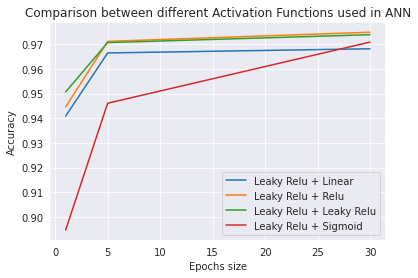

In [110]:

plt.xlabel("Epochs size")
plt.ylabel("Accuracy")
plt.title("Comparison between different Activation Functions used in ANN")
plt.plot(epochs_sizes, test_results_relu_linear_list, label = "Leaky Relu + Linear")
plt.plot(epochs_sizes, test_results_relu_leaky_list, label = "Leaky Relu + Relu ")
plt.plot(epochs_sizes, test_results_relu_relu_list, label = "Leaky Relu + Leaky Relu")
plt.plot(epochs_sizes, test_results_leaky_sigmoid_list, label = "Leaky Relu + Sigmoid")

plt.legend()
plt.show()

In [ ]:
# TODO: ASSIGN THE OPTIMAL ACTIVATION FUNCTION TO THIS GLOBAL VARIABLE
BEST_act1 = ACTIVATION_NAME() #FILL THIS WITH THE OPTIMAL ACTIVATION FUNCTION YOU FOUND OUT
BEST_act2 = ACTIVATION_NAME()

## 1.4 Discuss the results of the experiments (200 words max)

<!-- Your explanation will go here -->
Double-click to type here

---









# TASK 2 - Creating a twin kNN system for the ANN
---



In [115]:
# HELPER FUNCTIONS

#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)

def accuracy_knn(results):
        '''
        Returns the accuracy of predictions by comparing with the target
        results will be a List of Dictionaries. Each dictionary will contain
          the predicted value and the actual value
        '''
        correct = 0
        for predict, target in results:
            
            if predict == target:
                correct += 1
        return (correct/float(len(results))) * 100.0


def ann_prediction(ann_model, X, y):
    '''
    Returns predictions of an ANN model that are consistent with kNN test function
    '''
    results = [] # store the predictions returned by ANN
    pred = ann_model.predict(X)  # get the predictions
    predict_label_list = np.argmax(pred, axis=1)  # index of max value in list as predicted digit
    predict_label_list= predict_label_list.tolist()  # convert to list
    target_label_list = np.argmax(y, axis=1)  # index of max value in list as target digit
    target_label_list= target_label_list.tolist()  # convert to list
    for predict_label, target_label in zip(predict_label_list, target_label_list):
        results.append([predict_label, target_label])
    return results


## 2.1 Create a method to compute faithfulness between predictions

In [125]:
def faithfulness(predictions_1, predictions_2):
        '''
        Given two sets of predictions from two different ML algorithms, this will 
        check the rate of agreement between the two sets of predictions. 
        Here predictions_1 will be a List of Lists. Each inner List will contain a
          pair of predicted value and the actual value
        predictions_2 will be a List of Lists. Each inner List will contain a
          pair of predicted value and the actual value
        '''
        match = 0
        for pred in range(len(predictions_1)):
          if predictions_1[pred] == predictions_2[pred]:
            match += 1
        # TODO: compare predictions and maintain agreement

        
        return (match/float(len(predictions_1))) * 100.0

In [117]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        neighbours = [similarities[x] for x in range(self.k)] #extract the k top indices of the collection for return

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

In [118]:
# Set hyperparameters
ks = [1, 5, 11, 21, 51]  # try a few different values for k
train_size = 800 # or use the earlier specified "train_sample_size" which may take longer to compute
test_size = 200 # or use the earlier specified "test_sample_size" which may take longer to compute

## 2.2 Create a compressed version of the training and test sets using the ANN layer activations

In [119]:
# Use the following ANN configuration as your black-box model which needs a twinned kNN explanation
# Configure, Create and use this ANN to get embedings and predictions
batch_size = 20
epochs = 20
sgd = Optimizer_SGD()
lr = 0.3
# configure the layers
hidden_layer = Layer_Dense(784,200)
act1 = Activation_ReLU()
output_layer = Layer_Dense(200,10)
act2 = Activation_Sigmoid()

# create an ANN model
ann = ANN(output_layer, act2, hidden_layer, act1, sgd, batch_size) 
train_performance = ann.train(X_train, y_train, epochs, sgd, lr) # train the model


In [120]:
#  TODO: layer 1 compression - hint use ann.embeddings and flattened as needed
X_train_compressed_1 = ann.embeddings(X_train, "layer1")
X_test_compressed_1 =  ann.embeddings(X_test, "layer1")


# TODO: layer 2 compression - hint use ann.embeddings and flattened as needed
X_train_compressed_2 = ann.embeddings(X_train, "layer2")
X_test_compressed_2 = ann.embeddings(X_test, "layer2")


## 2.3 Setup an evaluation to compare to what extent a kNN aligns with the predictions of the ANN with the raw data versus the compressed data

In [123]:
# CONVERT Y Values to single class not one hot encoding
# because KNN implementation supports only one class
y_train_knn = np.argmax(y_train, axis=1)
y_train_knn= y_train_knn.tolist()

y_test_knn = np.argmax(y_test, axis=1)
y_test_knn= y_test_knn.tolist()


In [ ]:
# faithfulness using raw data (uncompressed)

knn_list = []
knn_exp = {"compression": "No Compression", "faithfulness": []}  # a dictionary to maintain compression type and faithfulness scores
for k in ks: # determine faithfulness for different values of k
  #create the different instances of the kNN class
  knn = kNN(X_train[:train_size], y_train_knn[:train_size], k, euclidean, weighted=True)
  knn.test(X_test[:test_size], y_test_knn[:test_size]) # now get the predictions on the test set
  knn_exp['faithfulness'].append(faithfulness(knn.results, ann_prediction(ann, X_test[:test_size], y_test[:test_size])))

print("kNN Faithfulness to ANN on test set is: ", knn_exp)
knn_list.append(knn_exp)


In [ ]:
# faithfulness using layer 1 compression


knn_exp = {"compression": "Layer 1 Compression", "faithfulness": []}

# TODO:
for k in ks:
  knn = kNN(X_train_compressed_1[:train_size],y_train_knn[:train_size], k, euclidean, weighted=True)
  knn.test(X_test_compressed_1[:test_size], y_test_knn[:test_size])
  knn_exp['faithfulness'].append(faithfulness(knn.results, ann_prediction(ann, X_test_compressed_1[:test_size], y_test[:test_size])))
  


print("kNN Faithfulness to ANN on test set is: ", knn_exp)
knn_list.append(knn_exp)

In [ ]:
# faithfulness using layer 2 compression

knn_exp = {"compression": "Layer 2 Compression", "faithfulness": []}

# TODO:



knn_list.append(knn_exp)

## 2.3 Plot a graph that compares the faithfulness of the uncompressed and compressed versions of kNN to ANN and explain findings

In [ ]:
N = len(ks) # this is the number of results we want to plot on the x-axis
ind = np.arange(N) # x axis index
# print(knn_list)

width = 0.25 # width of the bar      
plt.bar(ind, knn_list[0]['faithfulness'], width, label=knn_list[0]['compression'])

# TODO: add layer1 and 2 compressed results to the plot and format the graph




plt.show()

### Explain your findings in no more than 200 words.  

<!-- Your explanation will go here -->
Double-click to type here

---